# Knowledge Graph

In [1]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [2]:
candidate_sentences = pd.read_csv("miranda.csv")
candidate_sentences.shape

(1184, 1)

In [3]:
candidate_sentences.sample(5)

,text
516,"was sentenced years' imprisonment each count, the sentences run consecutively"
740,"but the merits are reached would affirm the ground that the State failed fulfill its burden, the absence showing that appropriate warnings were given, proving waiver totality circumstances showin..."
408,that time they were finally released
866,And suggest provide counsel for the suspect simply invites the end the interrogation
372,"But unless and until such warnings and waiver are demonstrated the prosecution trial, evidence obtained result interrogation can used against him"


In [4]:
#Check the POS with a sentence
doc = nlp("Such investigation may include inquiry persons not under restraint")

for tok in doc:
  print(tok.text, "...", tok.dep_)

Such ... amod
investigation ... nsubj
may ... aux
include ... ROOT
inquiry ... compound
persons ... dobj
not ... neg
under ... prep
restraint ... pobj


In [5]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [6]:
entity_pairs = []

for i in tqdm(candidate_sentences['text']):
  entity_pairs.append(get_entities(i))

entity_pairs

100%|█████████████████████████████████████████████████████████████████████████████| 1184/1184 [00:10<00:00, 114.38it/s]


[['', ''],
 ['', ''],
 ['', 'certiorari Appeals New York'],
 ['Ninth both', 'Ninth Circuit'],
 ['California Stewart', 'Supreme Court California'],
 ['prosecuting attorney which', 'outside  world'],
 ['defendants', 'full  rights'],
 ['well  which', 'trials'],
 ['convictions', 'one'],
 ['initiated law enforcement person', 'effective self incrimination'],
 ['incommunicado interrogation', 'inherently self incrimination'],
 ['truly  product', 'defendant'],
 ['chooses', 'official  investigations'],
 ['police interrogation', 'privilege'],
 ['lawyer', 'him'],
 ['questioning', 'attorney'],
 ['defendant', 'right  counsel'],
 ['questions', 'incustody right'],
 ['warnings', 'inculpatory  defendant'],
 ['proper system law FBI', 'other  jurisdictions'],
 ['that', 'constitutional self incrimination'],
 ['Telford Taylor', 'special State New York'],
 ['respective Attorneys States', 'Attorneys General'],
 ['brief', 'him'],
 ['Anthony Amsterdam', 'Civil Liberties Union'],
 ['MR CHIEF JUSTICE WARREN', 'op

In [7]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [8]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['text'])]
pd.Series(relations).value_counts()

100%|█████████████████████████████████████████████████████████████████████████████| 1184/1184 [00:09<00:00, 120.37it/s]


are              21
was              21
held             13
stated           11
made              9
                 ..
strained till     1
assure            1
found various     1
kidnapped         1
assessment        1
Length: 799, dtype: int64

In [9]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [10]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

C:\Users\subil\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\subil\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


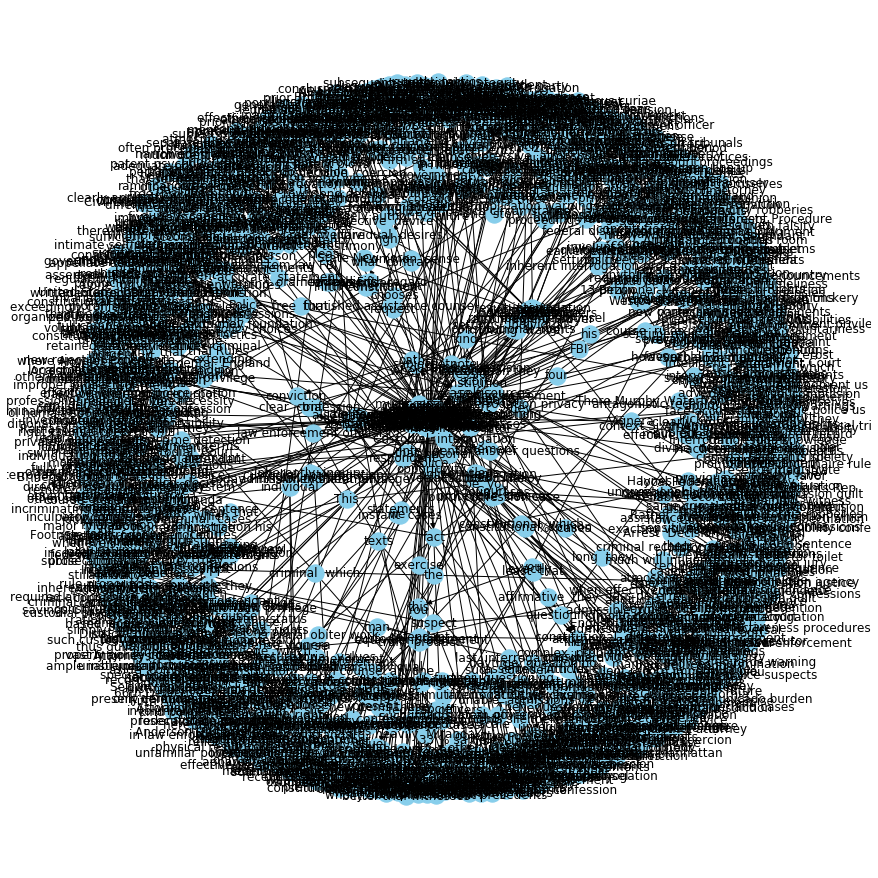

In [11]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.savefig('KG.png')
plt.show()


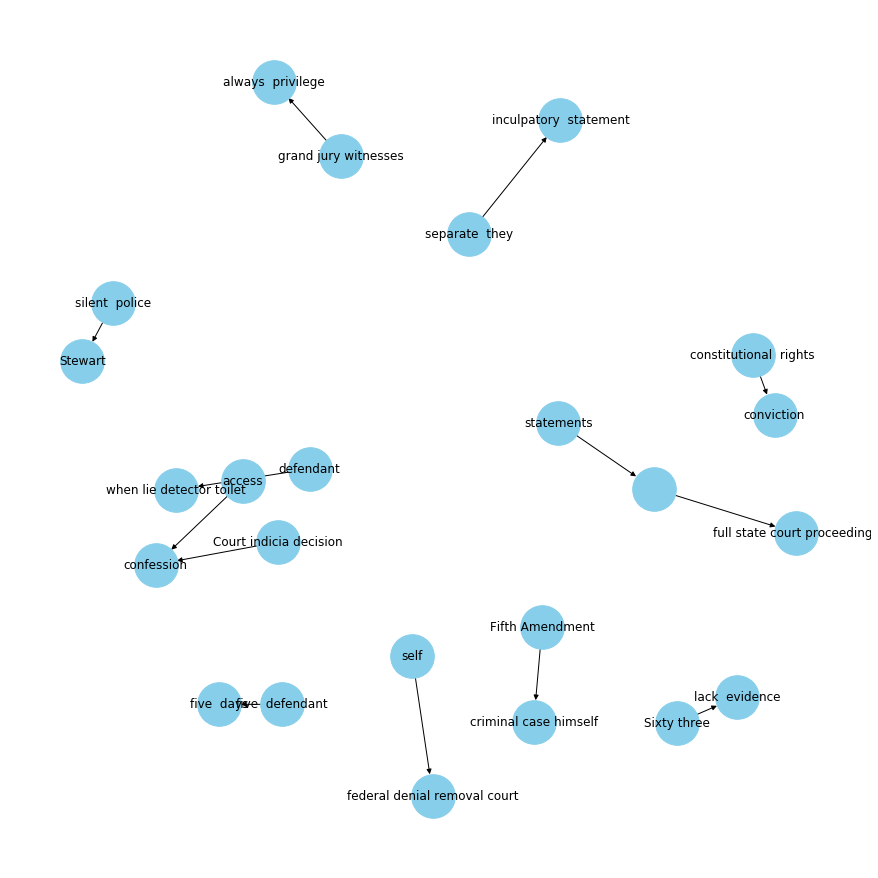

In [16]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="held"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.4) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1900, edge_cmap=plt.cm.Blues, pos = pos)
plt.savefig('Clean1.png')
plt.show()